# Notebook to test SetFit performance

Check CUDA

In [1]:
import torch
if torch.cuda.is_available():    
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

Load dataset and transform data

In [2]:
import pandas as pd
import numpy as np

dataFrame = pd.read_pickle(r'../data/7587_corrige.pkl')

In [3]:
subset = dataFrame[['jobTitle', 'description', 'label']].copy()

subset.reset_index(drop=True, inplace=True)
subset.replace('', np.nan, inplace=True)
subset.dropna(inplace=True)

subset['text'] = subset['jobTitle'] + ' ' + subset['description']
subset['label'] = np.where((subset["label"] < 3) | (subset["label"].isna()), 0, 1)
subset = subset[['text','label']]
subset

,text,label
2,Stagiaire ingénieur en intelligence artificiel...,1
3,Stagiaire en développement logiciel Développem...,0
4,Stagiaire en développement Web Création et évo...,0
5,Stagiaire en développement Web Portage d’une a...,0
6,Développeur Data / IA Développement d'applicat...,1
...,...,...
11281,Opérateur production Montage de transmission a...,0
11282,Opérateur production Montage de transmission a...,0
11283,Technicien réparation informatique Reparation ...,0
11284,Technicien réparation Reparation & maintenance...,0


Split the dataset in two: training and test set

In [4]:
from datasets import Dataset

def split_train_test(dataset, ratio):
    test_set = dataset.sample(frac = ratio, random_state=42)
    train_set = dataset.drop(test_set.index)
    return train_set, test_set

train_set, test_set = split_train_test(subset, 0.2)

# Functions to test different hyper parameters

In [5]:
import json
from datetime import datetime
import os


def save_to_json(object, folder_path):
	# Create folder if it doesn't exist
	if not os.path.exists(folder_path):
		os.makedirs(folder_path)
	# Generate file name
	date = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
	file_name = folder_path+'/'+str(date)+".txt"

	# Create file and save data
	with open(file_name, 'w') as file:
		json.dump(object, file)

In [6]:
from sentence_transformers.losses import CosineSimilarityLoss, BatchAllTripletLoss
from setfit import Trainer, TrainingArguments, sample_dataset, SetFitModel
import gc
import time

num_classes = 2

def get_transformer_model(model_name):
    model = SetFitModel.from_pretrained(model_name)
    gc.collect()
    torch.cuda.empty_cache()
    
    return model.to('cuda')

def init_trainer(model, loss, train_dataset, test_dataset):
    trainer_arguments = TrainingArguments(
        loss=loss,
        batch_size=(8,2),
        num_iterations=20, # Number of text pairs to generate for contrastive learning
        num_epochs=(1,10) # Number of epochs to use for contrastive learning (for the transformer and for the classification head)
    )

    trainer = Trainer(
        model=model,
        args=trainer_arguments,
        metric='f1',
        train_dataset=train_dataset,
        eval_dataset=test_dataset
    )
    return trainer

def setfit_f1_score(train_set, test_set, model_name, loss):   
    if len(train_set) <= 1 or len(test_set) <= 1:
        raise Exception
    
    model = get_transformer_model(model_name)
    trainer = init_trainer(model, loss, train_set, test_set)
    
    start_time = time.time()
    trainer.train()
    run_time = time.time() - start_time
    
    metrics = trainer.evaluate()
    
    del model
    del trainer
    torch.cuda.empty_cache()
    
    return metrics['f1'], run_time

In [7]:
from langdetect import detect

def filter_lang(df, lang):
    indices = []
    for i in range(len(df)):
        try:
            l = detect(df.iloc[i]["text"])
            if l == lang:
                indices.append(i)
        except:""
    
    return df.iloc[indices]

def filter_dataset(data, min_text_length=None, max_text_length=None, lang=None):
    if min_text_length is None:
        if max_text_length is None:
            filtered_data = data
        else:
            filtered_data = data[data['text'].str.split().apply(len) <= max_text_length]
    else:
        if max_text_length is None:
            filtered_data = data[data['text'].str.split().apply(len) >= min_text_length]
        else:
            filtered_data = data[data['text'].str.split().apply(len).between(min_text_length, max_text_length)]
            
    if not (lang is None):
        filtered_data = filter_lang(filtered_data, lang)
           
    return filtered_data

### N-Shots

In [8]:
#TODO: Save runtime

def n_shot_tests(params, train_set, test_set):
	n_values = params["n_shot"]
	n_iter = params["n_iter"]
	n_max_iter_per_shot = params["n_max_iter_per_shot"]
	model = params["model"]
	loss = params["loss"]
    
	n_values_max = np.max(n_values)

	results = {}
	run_times = {}
	for n_shot in n_values:
		results[n_shot] = []
		run_times[n_shot] = []
  
	# Repeat the tests multiple times because F1-score variations might be due to the examples chosen and not the input length of those examples
	for i in range(n_iter):
		print("Step:", i, "/", n_iter)
		# Use the same subset of the dataset for all of the tests in the following loop
		new_train_set = train_set.sample(frac = 1, random_state=i*47).groupby('label').head(n_values_max)
		new_train_set = Dataset.from_pandas(new_train_set, split="train")
		new_test_set = Dataset.from_pandas(test_set, split="test")

		for n_shot in n_values:
			if n_shot in results:
				try:
					n_iter_shot = n_max_iter_per_shot if n_shot < n_values_max else 1
					for i_shot in range(n_iter_shot):
						train_set_n_shot = sample_dataset(new_train_set, label_column="label", num_samples=n_shot, seed=47*n_shot + 3*i_shot)
						f1_score, run_time = setfit_f1_score(train_set_n_shot, new_test_set, model, loss)
						results[n_shot].append(f1_score)
						run_times[n_shot].append(run_time)
				except:""
	return results, run_times

### Input length

In [9]:
def input_length_tests(params, train_set, test_set):
	n_shot = params["n_shot"]
	len_values = params["input_length_range"]
	n_iter = params["n_iter"]
	model = params["model"]
	loss = params["loss"]
    
	results = {}
	run_times = {}
	new_test_set = Dataset.from_pandas(test_set, split="test")

	for i in range(len(len_values)):
		key = f"[{len_values[i][0]},{len_values[i][1]}]"
		results[key] = []
		run_times[key] = []
		
	results['all'] = []
	run_times['all'] = []

	# Repeat the tests multiple times because F1-score variations might be due to the examples chosen and not the input length of those examples
	for iter in range(n_iter):
		print("Step:", iter, "/", n_iter)
		for i in range(len(len_values)):
			key = f"[{len_values[i][0]},{len_values[i][1]}]"
			if key in results:
				try:
					new_train_set = filter_dataset(train_set, len_values[i][0], len_values[i][1])
					new_train_set = sample_dataset(new_train_set, label_column="label", num_samples=n_shot, seed=47*iter)
					f1_score, run_time = setfit_f1_score(new_train_set, new_test_set, model, loss)
					results[key].append(f1_score)
					run_times[key].append(run_time)
				except:""
	
		# Additional test (no length constraint)
		if 'all' in results:
			try:
				new_train_set = Dataset.from_pandas(train_set, split="train")
				new_train_set = sample_dataset(new_train_set, label_column="label", num_samples=n_shot, seed=47*iter)
				f1_score, run_time = setfit_f1_score(new_train_set, new_test_set, model, loss)
				results['all'].append(f1_score)
				run_times['all'].append(run_time)
			except:""
	return results, run_times

### Distance

In [10]:
def distance_tests(params, train_set, test_set):
	n_shot = params["n_shot"]
	n_iter = params["n_iter"]
	model = params["model"]
	losses = params["loss"]

	results = {}
	run_times = {}
	for key in losses.keys():
		results[key] = []
		run_times[key] = []

	new_test_set = Dataset.from_pandas(test_set, split="test")

	for i in range(n_iter):
		print("Step:", i, "/", n_iter)
		new_train_set = Dataset.from_pandas(train_set, split="train")
		new_train_set = sample_dataset(new_train_set, label_column="label", num_samples=n_shot, seed=47*i)
		
		for key in losses.keys():
			f1_score, run_time = setfit_f1_score(new_train_set, new_test_set, model, losses[key])
			results[key].append(f1_score)
			run_times[key].append(run_time)
	return results, run_times

### Language

In [11]:

def language_tests(params, train_set, test_set):
	n_shot = params["n_shot"]
	n_iter = params["n_iter"]
	model = params["model"]
	loss = params["loss"]
	languages = params["lang"]
 
	results = {}
	run_times = {}

	for key in languages:
		results[key] = []
		run_times[key] = []
	results['all'] = []
	run_times['all'] = []
 
	for i in range(n_iter):
		print("Step:", i, "/", n_iter)
		temp_train_set_panda = {}
		temp_test_set_panda = {}

		for key in languages:
			temp_train_set_panda[key] = filter_dataset(train_set, lang=key)
			temp_train_set = Dataset.from_pandas(temp_train_set_panda[key], split="train")
			temp_train_set = sample_dataset(temp_train_set, label_column="label", num_samples=n_shot, seed=47*i)
   
			temp_test_set_panda[key] = filter_dataset(test_set, lang=key)
			temp_test_set = Dataset.from_pandas(temp_test_set_panda[key], split="test")
			try:
				f1_score, run_time = setfit_f1_score(temp_train_set, temp_test_set, model, loss)
				results[key].append(f1_score)
				run_times[key].append(run_time)
			except Exception as err:
				del temp_train_set_panda[key]
				del temp_test_set_panda[key]
		
		all_temp_train_set = list(temp_train_set_panda.values())
		all_temp_test_set = list(temp_train_set_panda.values())
  
		if len(all_temp_train_set) == 0 or len(all_temp_test_set) == 0:
			continue

		all_train_set = pd.concat(all_temp_train_set)
		all_train_set = Dataset.from_pandas(all_train_set, split="test")
		all_train_set = sample_dataset(all_train_set, label_column="label", num_samples=n_shot, seed=47*i)
		all_test_set = pd.concat(all_temp_test_set)
		all_test_set = Dataset.from_pandas(all_test_set, split="test")
		try:
			f1_score, run_time = setfit_f1_score(all_train_set, all_test_set, model, loss)
			results['all'].append(f1_score)
			run_times['all'].append(run_time)
		except: ""
	return results, run_times

### Sentence transformers

Test SetFit with different ST models

In [12]:
def model_tests(params, train_set, test_set):
	n_shot = params["n_shot"]
	n_iter = params["n_iter"]
	loss = params["loss"]
	models = params["lang"]
 
	results = {}
	run_times = {}
	new_test_set = Dataset.from_pandas(test_set, split="test")

	for key in models.keys():
		results[key] = []
		run_times[key] = []

	for i in range(n_iter):
		print("Step:", i, "/", n_iter)

		# Use the same subset of the dataset for all of the tests in the following loop
		new_train_set = Dataset.from_pandas(train_set, split="train")
		new_train_set = sample_dataset(new_train_set, label_column="label", num_samples=n_shot, seed=47*i)

		for key, full_model_name in models.items():
			try:
				f1_score, run_time = setfit_f1_score(new_train_set, new_test_set, full_model_name, loss)
				results[key].append(f1_score)
				run_times[key].append(run_time)
			except: ""
	return results, run_times

## Run tests

In [13]:
def loss_to_str(loss):
    if loss == CosineSimilarityLoss:
        return "Cosine"
    elif loss == BatchAllTripletLoss:
        return "Triplet"
    else:
        return ""

### N-shots

In [14]:
params = {
	"n_shot": [1,5,10,30],
	"n_iter": 5,
 	"n_max_iter_per_shot": 3,
	"model": "sentence-transformers/paraphrase-mpnet-base-v2",
	"loss": CosineSimilarityLoss
}

results, run_times = n_shot_tests(params, train_set, test_set)

params["loss"] = loss_to_str(params["loss"])
save_to_json({"results":results, "run_times":run_times, "const_params": params},  r'../results/setfit/n_shot')

Step: 0 / 5


g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/2 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 80
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 10


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

{'embedding_loss': 0.1061, 'learning_rate': 2e-05, 'epoch': 0.1}
{'train_runtime': 4.813, 'train_samples_per_second': 16.622, 'train_steps_per_second': 2.078, 'epoch': 1.0}


***** Running evaluation *****
g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/2 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 80
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 10


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

{'embedding_loss': 0.0075, 'learning_rate': 2e-05, 'epoch': 0.1}


***** Running evaluation *****


{'train_runtime': 2.031, 'train_samples_per_second': 39.389, 'train_steps_per_second': 4.924, 'epoch': 1.0}


g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/2 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 80
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 10


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

{'embedding_loss': 0.0373, 'learning_rate': 2e-05, 'epoch': 0.1}


***** Running evaluation *****


{'train_runtime': 1.278, 'train_samples_per_second': 62.598, 'train_steps_per_second': 7.825, 'epoch': 1.0}


g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/4 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 160
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 20


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'embedding_loss': 0.0929, 'learning_rate': 1e-05, 'epoch': 0.05}


***** Running evaluation *****


{'train_runtime': 2.706, 'train_samples_per_second': 59.128, 'train_steps_per_second': 7.391, 'epoch': 1.0}


g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/4 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 160
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 20


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'embedding_loss': 0.1261, 'learning_rate': 1e-05, 'epoch': 0.05}
{'train_runtime': 8.198, 'train_samples_per_second': 19.517, 'train_steps_per_second': 2.44, 'epoch': 1.0}


***** Running evaluation *****
g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/4 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 160
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 20


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'embedding_loss': 0.1411, 'learning_rate': 1e-05, 'epoch': 0.05}
{'train_runtime': 6.123, 'train_samples_per_second': 26.131, 'train_steps_per_second': 3.266, 'epoch': 1.0}


***** Running evaluation *****
g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/10 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 400
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 50


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

{'embedding_loss': 0.0867, 'learning_rate': 4.000000000000001e-06, 'epoch': 0.02}


***** Running evaluation *****


{'embedding_loss': 0.0012, 'learning_rate': 0.0, 'epoch': 1.0}
{'train_runtime': 18.244, 'train_samples_per_second': 21.925, 'train_steps_per_second': 2.741, 'epoch': 1.0}


g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/10 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 400
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 50


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

{'embedding_loss': 0.2066, 'learning_rate': 4.000000000000001e-06, 'epoch': 0.02}
{'embedding_loss': 0.0016, 'learning_rate': 0.0, 'epoch': 1.0}
{'train_runtime': 66.483, 'train_samples_per_second': 6.017, 'train_steps_per_second': 0.752, 'epoch': 1.0}


***** Running evaluation *****
g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/10 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 400
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 50


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

{'embedding_loss': 0.1835, 'learning_rate': 4.000000000000001e-06, 'epoch': 0.02}


***** Running evaluation *****


{'embedding_loss': 0.0015, 'learning_rate': 0.0, 'epoch': 1.0}
{'train_runtime': 18.791, 'train_samples_per_second': 21.287, 'train_steps_per_second': 2.661, 'epoch': 1.0}


g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/20 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 800
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 100


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

{'embedding_loss': 0.222, 'learning_rate': 2.0000000000000003e-06, 'epoch': 0.01}
{'embedding_loss': 0.0008, 'learning_rate': 1.1111111111111113e-05, 'epoch': 0.5}
{'embedding_loss': 0.0005, 'learning_rate': 0.0, 'epoch': 1.0}
{'train_runtime': 75.2852, 'train_samples_per_second': 10.626, 'train_steps_per_second': 1.328, 'epoch': 1.0}


***** Running evaluation *****
g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/20 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 800
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 100


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

{'embedding_loss': 0.1493, 'learning_rate': 2.0000000000000003e-06, 'epoch': 0.01}
{'embedding_loss': 0.0013, 'learning_rate': 1.1111111111111113e-05, 'epoch': 0.5}
{'embedding_loss': 0.0002, 'learning_rate': 0.0, 'epoch': 1.0}
{'train_runtime': 117.022, 'train_samples_per_second': 6.836, 'train_steps_per_second': 0.855, 'epoch': 1.0}


***** Running evaluation *****
g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/20 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 800
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 100


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

{'embedding_loss': 0.2433, 'learning_rate': 2.0000000000000003e-06, 'epoch': 0.01}
{'embedding_loss': 0.0006, 'learning_rate': 1.1111111111111113e-05, 'epoch': 0.5}
{'embedding_loss': 0.0003, 'learning_rate': 0.0, 'epoch': 1.0}
{'train_runtime': 62.504, 'train_samples_per_second': 12.799, 'train_steps_per_second': 1.6, 'epoch': 1.0}


***** Running evaluation *****
g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/40 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 1600
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 200


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

{'embedding_loss': 0.3249, 'learning_rate': 1.0000000000000002e-06, 'epoch': 0.01}
{'embedding_loss': 0.0014, 'learning_rate': 1.6666666666666667e-05, 'epoch': 0.25}
{'embedding_loss': 0.0003, 'learning_rate': 1.1111111111111113e-05, 'epoch': 0.5}
{'embedding_loss': 0.0003, 'learning_rate': 5.555555555555557e-06, 'epoch': 0.75}
{'embedding_loss': 0.0001, 'learning_rate': 0.0, 'epoch': 1.0}
{'train_runtime': 103.973, 'train_samples_per_second': 15.389, 'train_steps_per_second': 1.924, 'epoch': 1.0}


***** Running evaluation *****


Step: 1 / 5


g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/2 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 80
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 10


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

{'embedding_loss': 0.0193, 'learning_rate': 2e-05, 'epoch': 0.1}
{'train_runtime': 2.611, 'train_samples_per_second': 30.64, 'train_steps_per_second': 3.83, 'epoch': 1.0}


***** Running evaluation *****
g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/2 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 80
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 10


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

{'embedding_loss': 0.0352, 'learning_rate': 2e-05, 'epoch': 0.1}


***** Running evaluation *****


{'train_runtime': 1.436, 'train_samples_per_second': 55.71, 'train_steps_per_second': 6.964, 'epoch': 1.0}


g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/2 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 80
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 10


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

{'embedding_loss': 0.197, 'learning_rate': 2e-05, 'epoch': 0.1}


***** Running evaluation *****


{'train_runtime': 11.253, 'train_samples_per_second': 7.109, 'train_steps_per_second': 0.889, 'epoch': 1.0}


g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/4 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 160
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 20


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'embedding_loss': 0.1408, 'learning_rate': 1e-05, 'epoch': 0.05}
{'train_runtime': 7.368, 'train_samples_per_second': 21.716, 'train_steps_per_second': 2.714, 'epoch': 1.0}


***** Running evaluation *****
g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/4 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 160
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 20


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'embedding_loss': 0.1477, 'learning_rate': 1e-05, 'epoch': 0.05}
{'train_runtime': 5.997, 'train_samples_per_second': 26.68, 'train_steps_per_second': 3.335, 'epoch': 1.0}


***** Running evaluation *****
g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/4 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 160
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 20


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'embedding_loss': 0.1397, 'learning_rate': 1e-05, 'epoch': 0.05}
{'train_runtime': 7.051, 'train_samples_per_second': 22.692, 'train_steps_per_second': 2.836, 'epoch': 1.0}


***** Running evaluation *****
g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/10 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 400
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 50


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

{'embedding_loss': 0.0825, 'learning_rate': 4.000000000000001e-06, 'epoch': 0.02}


***** Running evaluation *****


{'embedding_loss': 0.0022, 'learning_rate': 0.0, 'epoch': 1.0}
{'train_runtime': 16.431, 'train_samples_per_second': 24.344, 'train_steps_per_second': 3.043, 'epoch': 1.0}


g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/10 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 400
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 50


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

{'embedding_loss': 0.1829, 'learning_rate': 4.000000000000001e-06, 'epoch': 0.02}


***** Running evaluation *****


{'embedding_loss': 0.0023, 'learning_rate': 0.0, 'epoch': 1.0}
{'train_runtime': 17.629, 'train_samples_per_second': 22.69, 'train_steps_per_second': 2.836, 'epoch': 1.0}


g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/10 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 400
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 50


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

{'embedding_loss': 0.2016, 'learning_rate': 4.000000000000001e-06, 'epoch': 0.02}


***** Running evaluation *****


{'embedding_loss': 0.0039, 'learning_rate': 0.0, 'epoch': 1.0}
{'train_runtime': 17.042, 'train_samples_per_second': 23.471, 'train_steps_per_second': 2.934, 'epoch': 1.0}


g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/20 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 800
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 100


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

{'embedding_loss': 0.2138, 'learning_rate': 2.0000000000000003e-06, 'epoch': 0.01}
{'embedding_loss': 0.0018, 'learning_rate': 1.1111111111111113e-05, 'epoch': 0.5}
{'embedding_loss': 0.0003, 'learning_rate': 0.0, 'epoch': 1.0}
{'train_runtime': 79.592, 'train_samples_per_second': 10.051, 'train_steps_per_second': 1.256, 'epoch': 1.0}


***** Running evaluation *****
g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/20 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 800
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 100


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

{'embedding_loss': 0.179, 'learning_rate': 2.0000000000000003e-06, 'epoch': 0.01}
{'embedding_loss': 0.0043, 'learning_rate': 1.1111111111111113e-05, 'epoch': 0.5}
{'embedding_loss': 0.0011, 'learning_rate': 0.0, 'epoch': 1.0}
{'train_runtime': 110.1861, 'train_samples_per_second': 7.26, 'train_steps_per_second': 0.908, 'epoch': 1.0}


***** Running evaluation *****
g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/20 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 800
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 100


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

{'embedding_loss': 0.223, 'learning_rate': 2.0000000000000003e-06, 'epoch': 0.01}
{'embedding_loss': 0.0008, 'learning_rate': 1.1111111111111113e-05, 'epoch': 0.5}
{'embedding_loss': 0.0007, 'learning_rate': 0.0, 'epoch': 1.0}
{'train_runtime': 35.707, 'train_samples_per_second': 22.405, 'train_steps_per_second': 2.801, 'epoch': 1.0}


***** Running evaluation *****
g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/40 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 1600
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 200


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

{'embedding_loss': 0.2592, 'learning_rate': 1.0000000000000002e-06, 'epoch': 0.01}
{'embedding_loss': 0.012, 'learning_rate': 1.6666666666666667e-05, 'epoch': 0.25}
{'embedding_loss': 0.0008, 'learning_rate': 1.1111111111111113e-05, 'epoch': 0.5}
{'embedding_loss': 0.0006, 'learning_rate': 5.555555555555557e-06, 'epoch': 0.75}
{'embedding_loss': 0.0004, 'learning_rate': 0.0, 'epoch': 1.0}
{'train_runtime': 97.99, 'train_samples_per_second': 16.328, 'train_steps_per_second': 2.041, 'epoch': 1.0}


***** Running evaluation *****


Step: 2 / 5


g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/2 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 80
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 10


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

{'embedding_loss': 0.0232, 'learning_rate': 2e-05, 'epoch': 0.1}


***** Running evaluation *****


{'train_runtime': 1.92, 'train_samples_per_second': 41.667, 'train_steps_per_second': 5.208, 'epoch': 1.0}


g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/2 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 80
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 10


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

{'embedding_loss': 0.0145, 'learning_rate': 2e-05, 'epoch': 0.1}


***** Running evaluation *****


{'train_runtime': 1.833, 'train_samples_per_second': 43.644, 'train_steps_per_second': 5.456, 'epoch': 1.0}


g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/2 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 80
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 10


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

{'embedding_loss': 0.0794, 'learning_rate': 2e-05, 'epoch': 0.1}


***** Running evaluation *****


{'train_runtime': 1.926, 'train_samples_per_second': 41.537, 'train_steps_per_second': 5.192, 'epoch': 1.0}


g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/4 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 160
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 20


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'embedding_loss': 0.1205, 'learning_rate': 1e-05, 'epoch': 0.05}
{'train_runtime': 5.652, 'train_samples_per_second': 28.309, 'train_steps_per_second': 3.539, 'epoch': 1.0}


***** Running evaluation *****
g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/4 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 160
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 20


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'embedding_loss': 0.1988, 'learning_rate': 1e-05, 'epoch': 0.05}
{'train_runtime': 10.386, 'train_samples_per_second': 15.405, 'train_steps_per_second': 1.926, 'epoch': 1.0}


***** Running evaluation *****
g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/4 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 160
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 20


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'embedding_loss': 0.1047, 'learning_rate': 1e-05, 'epoch': 0.05}
{'train_runtime': 7.072, 'train_samples_per_second': 22.624, 'train_steps_per_second': 2.828, 'epoch': 1.0}


***** Running evaluation *****
g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/10 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 400
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 50


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

{'embedding_loss': 0.1544, 'learning_rate': 4.000000000000001e-06, 'epoch': 0.02}


***** Running evaluation *****


{'embedding_loss': 0.0013, 'learning_rate': 0.0, 'epoch': 1.0}
{'train_runtime': 21.385, 'train_samples_per_second': 18.705, 'train_steps_per_second': 2.338, 'epoch': 1.0}


g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/10 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 400
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 50


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

{'embedding_loss': 0.2627, 'learning_rate': 4.000000000000001e-06, 'epoch': 0.02}


***** Running evaluation *****


{'embedding_loss': 0.0014, 'learning_rate': 0.0, 'epoch': 1.0}
{'train_runtime': 24.358, 'train_samples_per_second': 16.422, 'train_steps_per_second': 2.053, 'epoch': 1.0}


g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/10 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 400
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 50


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

{'embedding_loss': 0.1803, 'learning_rate': 4.000000000000001e-06, 'epoch': 0.02}


***** Running evaluation *****


{'embedding_loss': 0.0039, 'learning_rate': 0.0, 'epoch': 1.0}
{'train_runtime': 23.36, 'train_samples_per_second': 17.123, 'train_steps_per_second': 2.14, 'epoch': 1.0}


g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/20 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 800
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 100


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

{'embedding_loss': 0.2066, 'learning_rate': 2.0000000000000003e-06, 'epoch': 0.01}
{'embedding_loss': 0.0014, 'learning_rate': 1.1111111111111113e-05, 'epoch': 0.5}
{'embedding_loss': 0.0004, 'learning_rate': 0.0, 'epoch': 1.0}
{'train_runtime': 43.213, 'train_samples_per_second': 18.513, 'train_steps_per_second': 2.314, 'epoch': 1.0}


***** Running evaluation *****
g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/20 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 800
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 100


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

{'embedding_loss': 0.1909, 'learning_rate': 2.0000000000000003e-06, 'epoch': 0.01}
{'embedding_loss': 0.0019, 'learning_rate': 1.1111111111111113e-05, 'epoch': 0.5}
{'embedding_loss': 0.0003, 'learning_rate': 0.0, 'epoch': 1.0}
{'train_runtime': 50.779, 'train_samples_per_second': 15.755, 'train_steps_per_second': 1.969, 'epoch': 1.0}


***** Running evaluation *****
g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/20 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 800
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 100


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

{'embedding_loss': 0.3169, 'learning_rate': 2.0000000000000003e-06, 'epoch': 0.01}
{'embedding_loss': 0.0013, 'learning_rate': 1.1111111111111113e-05, 'epoch': 0.5}


***** Running evaluation *****


{'embedding_loss': 0.0009, 'learning_rate': 0.0, 'epoch': 1.0}
{'train_runtime': 31.68, 'train_samples_per_second': 25.253, 'train_steps_per_second': 3.157, 'epoch': 1.0}


g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/40 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 1600
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 200


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

{'embedding_loss': 0.2111, 'learning_rate': 1.0000000000000002e-06, 'epoch': 0.01}
{'embedding_loss': 0.0233, 'learning_rate': 1.6666666666666667e-05, 'epoch': 0.25}
{'embedding_loss': 0.0003, 'learning_rate': 1.1111111111111113e-05, 'epoch': 0.5}
{'embedding_loss': 0.0002, 'learning_rate': 5.555555555555557e-06, 'epoch': 0.75}
{'embedding_loss': 0.0001, 'learning_rate': 0.0, 'epoch': 1.0}
{'train_runtime': 86.872, 'train_samples_per_second': 18.418, 'train_steps_per_second': 2.302, 'epoch': 1.0}


***** Running evaluation *****


Step: 3 / 5


g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/2 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 80
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 10


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

{'embedding_loss': 0.118, 'learning_rate': 2e-05, 'epoch': 0.1}
{'train_runtime': 2.712, 'train_samples_per_second': 29.499, 'train_steps_per_second': 3.687, 'epoch': 1.0}


***** Running evaluation *****
g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/2 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 80
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 10


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

{'embedding_loss': 0.0179, 'learning_rate': 2e-05, 'epoch': 0.1}
{'train_runtime': 4.94, 'train_samples_per_second': 16.194, 'train_steps_per_second': 2.024, 'epoch': 1.0}


***** Running evaluation *****
g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/2 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 80
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 10


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

{'embedding_loss': 0.0773, 'learning_rate': 2e-05, 'epoch': 0.1}
{'train_runtime': 2.763, 'train_samples_per_second': 28.954, 'train_steps_per_second': 3.619, 'epoch': 1.0}


***** Running evaluation *****
g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/4 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 160
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 20


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'embedding_loss': 0.132, 'learning_rate': 1e-05, 'epoch': 0.05}
{'train_runtime': 5.654, 'train_samples_per_second': 28.299, 'train_steps_per_second': 3.537, 'epoch': 1.0}


***** Running evaluation *****
g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/4 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 160
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 20


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'embedding_loss': 0.1572, 'learning_rate': 1e-05, 'epoch': 0.05}
{'train_runtime': 6.32, 'train_samples_per_second': 25.316, 'train_steps_per_second': 3.165, 'epoch': 1.0}


***** Running evaluation *****
g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/4 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 160
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 20


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'embedding_loss': 0.1457, 'learning_rate': 1e-05, 'epoch': 0.05}
{'train_runtime': 6.34, 'train_samples_per_second': 25.237, 'train_steps_per_second': 3.155, 'epoch': 1.0}


***** Running evaluation *****
g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/10 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 400
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 50


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

{'embedding_loss': 0.1525, 'learning_rate': 4.000000000000001e-06, 'epoch': 0.02}


***** Running evaluation *****


{'embedding_loss': 0.002, 'learning_rate': 0.0, 'epoch': 1.0}
{'train_runtime': 22.577, 'train_samples_per_second': 17.717, 'train_steps_per_second': 2.215, 'epoch': 1.0}


g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/10 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 400
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 50


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

{'embedding_loss': 0.1765, 'learning_rate': 4.000000000000001e-06, 'epoch': 0.02}


***** Running evaluation *****


{'embedding_loss': 0.0011, 'learning_rate': 0.0, 'epoch': 1.0}
{'train_runtime': 21.562, 'train_samples_per_second': 18.551, 'train_steps_per_second': 2.319, 'epoch': 1.0}


g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/10 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 400
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 50


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

{'embedding_loss': 0.2647, 'learning_rate': 4.000000000000001e-06, 'epoch': 0.02}


***** Running evaluation *****


{'embedding_loss': 0.0032, 'learning_rate': 0.0, 'epoch': 1.0}
{'train_runtime': 15.275, 'train_samples_per_second': 26.187, 'train_steps_per_second': 3.273, 'epoch': 1.0}


g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/20 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 800
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 100


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

{'embedding_loss': 0.1999, 'learning_rate': 2.0000000000000003e-06, 'epoch': 0.01}
{'embedding_loss': 0.0003, 'learning_rate': 1.1111111111111113e-05, 'epoch': 0.5}
{'embedding_loss': 0.0003, 'learning_rate': 0.0, 'epoch': 1.0}
{'train_runtime': 48.815, 'train_samples_per_second': 16.388, 'train_steps_per_second': 2.049, 'epoch': 1.0}


***** Running evaluation *****
g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/20 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 800
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 100


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

{'embedding_loss': 0.2612, 'learning_rate': 2.0000000000000003e-06, 'epoch': 0.01}
{'embedding_loss': 0.0029, 'learning_rate': 1.1111111111111113e-05, 'epoch': 0.5}
{'embedding_loss': 0.0015, 'learning_rate': 0.0, 'epoch': 1.0}
{'train_runtime': 40.936, 'train_samples_per_second': 19.543, 'train_steps_per_second': 2.443, 'epoch': 1.0}


***** Running evaluation *****
g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/20 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 800
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 100


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

{'embedding_loss': 0.2305, 'learning_rate': 2.0000000000000003e-06, 'epoch': 0.01}
{'embedding_loss': 0.0034, 'learning_rate': 1.1111111111111113e-05, 'epoch': 0.5}


***** Running evaluation *****


{'embedding_loss': 0.0011, 'learning_rate': 0.0, 'epoch': 1.0}
{'train_runtime': 35.917, 'train_samples_per_second': 22.274, 'train_steps_per_second': 2.784, 'epoch': 1.0}


g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/40 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 1600
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 200


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

{'embedding_loss': 0.2481, 'learning_rate': 1.0000000000000002e-06, 'epoch': 0.01}
{'embedding_loss': 0.0227, 'learning_rate': 1.6666666666666667e-05, 'epoch': 0.25}
{'embedding_loss': 0.0007, 'learning_rate': 1.1111111111111113e-05, 'epoch': 0.5}
{'embedding_loss': 0.0006, 'learning_rate': 5.555555555555557e-06, 'epoch': 0.75}
{'embedding_loss': 0.0001, 'learning_rate': 0.0, 'epoch': 1.0}
{'train_runtime': 83.719, 'train_samples_per_second': 19.112, 'train_steps_per_second': 2.389, 'epoch': 1.0}


***** Running evaluation *****


Step: 4 / 5


g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/2 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 80
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 10


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

{'embedding_loss': 0.0573, 'learning_rate': 2e-05, 'epoch': 0.1}
{'train_runtime': 4.9725, 'train_samples_per_second': 16.088, 'train_steps_per_second': 2.011, 'epoch': 1.0}


***** Running evaluation *****
g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/2 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 80
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 10


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

{'embedding_loss': 0.1391, 'learning_rate': 2e-05, 'epoch': 0.1}
{'train_runtime': 3.0817, 'train_samples_per_second': 25.959, 'train_steps_per_second': 3.245, 'epoch': 1.0}


***** Running evaluation *****
g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/2 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 80
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 10


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

{'embedding_loss': 0.0165, 'learning_rate': 2e-05, 'epoch': 0.1}


***** Running evaluation *****


{'train_runtime': 1.453, 'train_samples_per_second': 55.059, 'train_steps_per_second': 6.882, 'epoch': 1.0}


g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/4 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 160
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 20


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'embedding_loss': 0.1274, 'learning_rate': 1e-05, 'epoch': 0.05}
{'train_runtime': 11.0165, 'train_samples_per_second': 14.524, 'train_steps_per_second': 1.815, 'epoch': 1.0}


***** Running evaluation *****
g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/4 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 160
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 20


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'embedding_loss': 0.1662, 'learning_rate': 1e-05, 'epoch': 0.05}


***** Running evaluation *****


{'train_runtime': 5.0, 'train_samples_per_second': 32.0, 'train_steps_per_second': 4.0, 'epoch': 1.0}


g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/4 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 160
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 20


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'embedding_loss': 0.1422, 'learning_rate': 1e-05, 'epoch': 0.05}
{'train_runtime': 6.72, 'train_samples_per_second': 23.81, 'train_steps_per_second': 2.976, 'epoch': 1.0}


***** Running evaluation *****
g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/10 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 400
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 50


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

{'embedding_loss': 0.1397, 'learning_rate': 4.000000000000001e-06, 'epoch': 0.02}


***** Running evaluation *****


{'embedding_loss': 0.0008, 'learning_rate': 0.0, 'epoch': 1.0}
{'train_runtime': 21.5535, 'train_samples_per_second': 18.558, 'train_steps_per_second': 2.32, 'epoch': 1.0}


g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/10 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 400
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 50


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

{'embedding_loss': 0.1914, 'learning_rate': 4.000000000000001e-06, 'epoch': 0.02}


***** Running evaluation *****


{'embedding_loss': 0.0012, 'learning_rate': 0.0, 'epoch': 1.0}
{'train_runtime': 26.0542, 'train_samples_per_second': 15.353, 'train_steps_per_second': 1.919, 'epoch': 1.0}


g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/10 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 400
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 50


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

{'embedding_loss': 0.2642, 'learning_rate': 4.000000000000001e-06, 'epoch': 0.02}


***** Running evaluation *****


{'embedding_loss': 0.0024, 'learning_rate': 0.0, 'epoch': 1.0}
{'train_runtime': 14.029, 'train_samples_per_second': 28.512, 'train_steps_per_second': 3.564, 'epoch': 1.0}


g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/20 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 800
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 100


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

{'embedding_loss': 0.1876, 'learning_rate': 2.0000000000000003e-06, 'epoch': 0.01}
{'embedding_loss': 0.0011, 'learning_rate': 1.1111111111111113e-05, 'epoch': 0.5}
{'embedding_loss': 0.0008, 'learning_rate': 0.0, 'epoch': 1.0}
{'train_runtime': 49.849, 'train_samples_per_second': 16.048, 'train_steps_per_second': 2.006, 'epoch': 1.0}


***** Running evaluation *****
g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/20 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 800
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 100


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

{'embedding_loss': 0.2349, 'learning_rate': 2.0000000000000003e-06, 'epoch': 0.01}
{'embedding_loss': 0.0042, 'learning_rate': 1.1111111111111113e-05, 'epoch': 0.5}


g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/40 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 1600
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 200


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

{'embedding_loss': 0.2578, 'learning_rate': 1.0000000000000002e-06, 'epoch': 0.01}


### Input length

In [ ]:
params = {
    "input_length_range": [(0,1),(0,3)], #[(0,1),(0,5),(0,10),(0,50),(0,100),(0,200),(5,None),(150,None)]
	"n_shot": 8,
	"n_iter": 2, #5
	"model": "sentence-transformers/paraphrase-mpnet-base-v2",
	"loss": CosineSimilarityLoss
}

results, run_times = input_length_tests(params, train_set, test_set)

params["loss"] = loss_to_str(params["loss"])
save_to_json({"results":results, "run_times":run_times},  r'../results/setfit/input_length')

Step: 0 / 2


g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 640
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 80


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

{'embedding_loss': 0.1091, 'learning_rate': 2.5e-06, 'epoch': 0.01}
{'embedding_loss': 0.0014, 'learning_rate': 8.333333333333334e-06, 'epoch': 0.62}
{'train_runtime': 31.153, 'train_samples_per_second': 20.544, 'train_steps_per_second': 2.568, 'epoch': 1.0}


***** Running evaluation *****


Step: 1 / 2


g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 640
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 80


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

{'embedding_loss': 0.1091, 'learning_rate': 2.5e-06, 'epoch': 0.01}
{'embedding_loss': 0.0014, 'learning_rate': 8.333333333333334e-06, 'epoch': 0.62}
{'train_runtime': 31.892, 'train_samples_per_second': 20.068, 'train_steps_per_second': 2.508, 'epoch': 1.0}


***** Running evaluation *****


### Distance

In [ ]:
params = {
	"n_shot": 8,
	"n_iter": 10,
	"model": "sentence-transformers/paraphrase-mpnet-base-v2",
	"loss": {"Cosine":CosineSimilarityLoss, "Triplet":BatchAllTripletLoss}
}

results, run_times = distance_tests(params, train_set, test_set)

for key in params["loss"].keys():
    params["loss"][key] = loss_to_str(params["loss"][key])
save_to_json({"results":results, "run_times":run_times},  r'../results/setfit/distance')

Step: 0 / 2


g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 640
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 80


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

{'embedding_loss': 0.2005, 'learning_rate': 2.5e-06, 'epoch': 0.01}
{'embedding_loss': 0.0006, 'learning_rate': 8.333333333333334e-06, 'epoch': 0.62}
{'train_runtime': 36.664, 'train_samples_per_second': 17.456, 'train_steps_per_second': 2.182, 'epoch': 1.0}


***** Running evaluation *****
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 16
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 2


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

{'embedding_loss': 0.1767, 'learning_rate': 2e-05, 'epoch': 0.5}
{'train_runtime': 0.666, 'train_samples_per_second': 24.024, 'train_steps_per_second': 3.003, 'epoch': 1.0}


***** Running evaluation *****


Step: 1 / 2


g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 640
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 80


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

{'embedding_loss': 0.1772, 'learning_rate': 2.5e-06, 'epoch': 0.01}
{'embedding_loss': 0.0003, 'learning_rate': 8.333333333333334e-06, 'epoch': 0.62}
{'train_runtime': 42.3677, 'train_samples_per_second': 15.106, 'train_steps_per_second': 1.888, 'epoch': 1.0}


***** Running evaluation *****
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 16
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 2


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

{'embedding_loss': 0.1986, 'learning_rate': 2e-05, 'epoch': 0.5}
{'train_runtime': 0.635, 'train_samples_per_second': 25.197, 'train_steps_per_second': 3.15, 'epoch': 1.0}


***** Running evaluation *****


### Language

In [ ]:
params = {
	"n_shot": 8,
	"lang": ['fr','en'],
	"n_iter": 10,
	"model": "sentence-transformers/paraphrase-mpnet-base-v2",
	"loss": CosineSimilarityLoss
}

results, run_times = language_tests(params, train_set, test_set)

params["loss"] = loss_to_str(params["loss"])
save_to_json({"results":results, "run_times":run_times},  r'../results/setfit/language')

Step: 0 / 2


g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/6 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 240
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 30


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

{'embedding_loss': 0.1997, 'learning_rate': 6.666666666666667e-06, 'epoch': 0.03}
{'train_runtime': 15.387, 'train_samples_per_second': 15.598, 'train_steps_per_second': 1.95, 'epoch': 1.0}


***** Running evaluation *****
g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/6 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 240
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 30


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

{'embedding_loss': 0.1307, 'learning_rate': 6.666666666666667e-06, 'epoch': 0.03}
{'train_runtime': 11.4541, 'train_samples_per_second': 20.953, 'train_steps_per_second': 2.619, 'epoch': 1.0}


***** Running evaluation *****
g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/6 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 240
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 30


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

{'embedding_loss': 0.1197, 'learning_rate': 6.666666666666667e-06, 'epoch': 0.03}
{'train_runtime': 10.1416, 'train_samples_per_second': 23.665, 'train_steps_per_second': 2.958, 'epoch': 1.0}


***** Running evaluation *****


Step: 1 / 2


g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/6 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 240
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 30


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

{'embedding_loss': 0.1588, 'learning_rate': 6.666666666666667e-06, 'epoch': 0.03}
{'train_runtime': 8.9824, 'train_samples_per_second': 26.719, 'train_steps_per_second': 3.34, 'epoch': 1.0}


***** Running evaluation *****
g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/6 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 240
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 30


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

{'embedding_loss': 0.1389, 'learning_rate': 6.666666666666667e-06, 'epoch': 0.03}


***** Running evaluation *****


{'train_runtime': 4.863, 'train_samples_per_second': 49.352, 'train_steps_per_second': 6.169, 'epoch': 1.0}


g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/6 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 240
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 30


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

{'embedding_loss': 0.1286, 'learning_rate': 6.666666666666667e-06, 'epoch': 0.03}
{'train_runtime': 8.7236, 'train_samples_per_second': 27.512, 'train_steps_per_second': 3.439, 'epoch': 1.0}


***** Running evaluation *****


### Sentence transformers

In [ ]:
params = {
	"n_shot": 8,
	"n_iter": 5,
	"loss": CosineSimilarityLoss,
	"model": {
		"paraphrase-mpnet-base-v2": "sentence-transformers/paraphrase-mpnet-base-v2",
		"all-MiniLM-L6-v2": "sentence-transformers/all-MiniLM-L6-v2",
		"paraphrase-multilingual-MiniLM-L12-v2": "sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2",
		"paraphrase-multilingual-mpnet-base-v2": "sentence-transformers/paraphrase-multilingual-mpnet-base-v2",
		"multilingual-e5-small": "intfloat/multilingual-e5-small",
		"all-distilroberta-v1": "sentence-transformers/all-distilroberta-v1",
		"msmarco-distilbert-dot-v5": "sentence-transformers/msmarco-distilbert-dot-v5",
		"bge-small-en-v1.5": "BAAI/bge-small-en-v1.5",
		"all-roberta-large-v1": "sentence-transformers/all-roberta-large-v1"
	}
}

results, run_times = language_tests(params, train_set, test_set)

params["loss"] = loss_to_str(params["loss"])
save_to_json({"results":results, "run_times":run_times},  r'../results/setfit/model')

Step: 0 / 2


g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 640
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 80


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

{'embedding_loss': 0.2005, 'learning_rate': 2.5e-06, 'epoch': 0.01}
{'embedding_loss': 0.0006, 'learning_rate': 8.333333333333334e-06, 'epoch': 0.62}
{'train_runtime': 37.683, 'train_samples_per_second': 16.984, 'train_steps_per_second': 2.123, 'epoch': 1.0}


***** Running evaluation *****
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 640
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 80


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

{'embedding_loss': 0.1918, 'learning_rate': 2.5e-06, 'epoch': 0.01}
{'embedding_loss': 0.0006, 'learning_rate': 8.333333333333334e-06, 'epoch': 0.62}
{'train_runtime': 23.8116, 'train_samples_per_second': 26.878, 'train_steps_per_second': 3.36, 'epoch': 1.0}


***** Running evaluation *****


Step: 1 / 2


g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 640
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 80


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

{'embedding_loss': 0.1772, 'learning_rate': 2.5e-06, 'epoch': 0.01}
{'embedding_loss': 0.0003, 'learning_rate': 8.333333333333334e-06, 'epoch': 0.62}
{'train_runtime': 40.87, 'train_samples_per_second': 15.659, 'train_steps_per_second': 1.957, 'epoch': 1.0}


***** Running evaluation *****
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 640
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 80


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

{'embedding_loss': 0.2052, 'learning_rate': 2.5e-06, 'epoch': 0.01}
{'embedding_loss': 0.0003, 'learning_rate': 8.333333333333334e-06, 'epoch': 0.62}
{'train_runtime': 24.59, 'train_samples_per_second': 26.027, 'train_steps_per_second': 3.253, 'epoch': 1.0}


***** Running evaluation *****


## Graphs

In [ ]:
import matplotlib.pyplot as plt

def load_results_data(filename, folder):
	with open(folder+"/"+filename, 'r') as file:
		data = json.load(file)
 
	return data['results'], data['run_times']

def load_latest_results_data(folder):
	filenames = os.listdir(folder)
	latest = max(filenames, key=lambda x: os.path.getmtime(os.path.join(folder, x)))
	return load_results_data(latest, folder)

def create_scatter_line_plot(data, title, xlabel, ylabel):
	resultsMeans = {}

	for key in data.keys():
		resultsMeans[key] = np.mean(data[key])

	xMean = list(resultsMeans.keys())
	yMean = list(resultsMeans.values())

	listOfLists = list(data.values())

	xAll = []
	for i in range(len(listOfLists)): # for each key
		for _ in range(len(listOfLists[i])): # for each repetition of the key
			xAll.append(xMean[i])
	yAll = np.concatenate(list(data.values()))
	
	plt.figure(figsize=(8, 6))
	plt.plot(xMean, yMean, marker='', linestyle='-')
	plt.scatter(xAll, yAll)
	
	for i, (xi, yi) in enumerate(zip(xMean, yMean)):
		plt.annotate(f'{yi:.2f}', (xi, yi), textcoords="offset points", xytext=(0, 10), ha='center')
	
	plt.title(title)
	plt.xlabel(xlabel)
	plt.ylabel(ylabel)
	
	plt.grid(True)
	plt.show()

def create_bar_plot(data, title, xlabel, ylabel):
	resultsMeans = {}

	for key in data.keys():
		resultsMeans[key] = np.mean(data[key])

	xMean = list(resultsMeans.keys())
	yMean = list(resultsMeans.values())
	
	plt.figure(figsize=(11, 6))
	plt.xticks(fontsize=15)
	plt.yticks(fontsize=15)
	plt.bar(xMean, yMean)

	plt.title(title)
	plt.xlabel(xlabel)
	plt.ylabel(ylabel)

	plt.show()

### Plot graphs

g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\matplotlib\text.py:1461: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = float(self.convert_xunits(x))


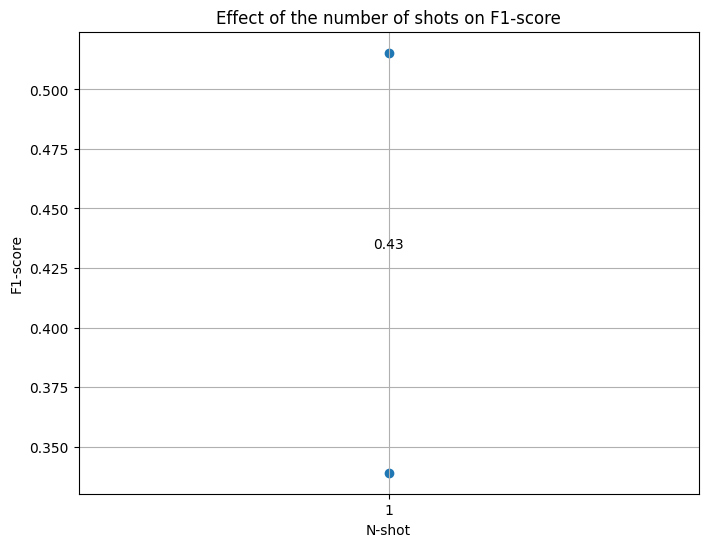

g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


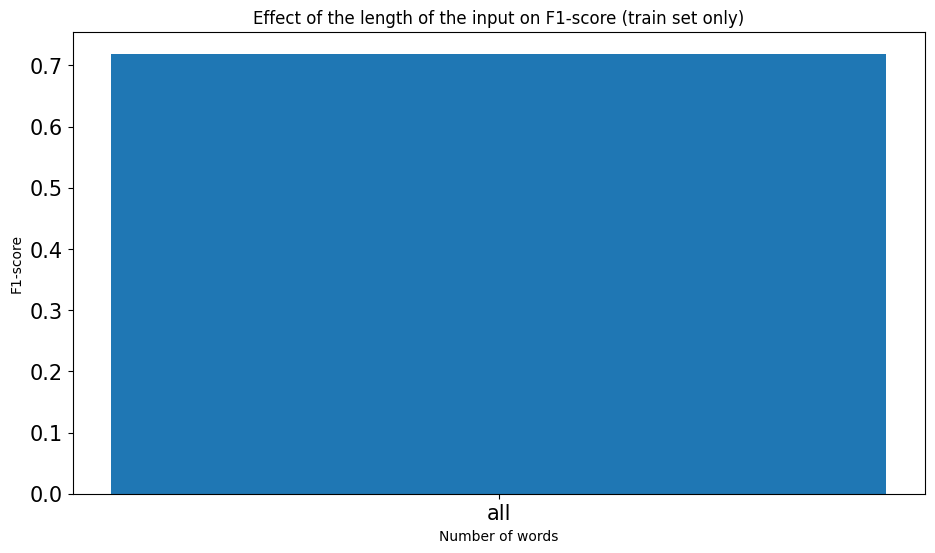

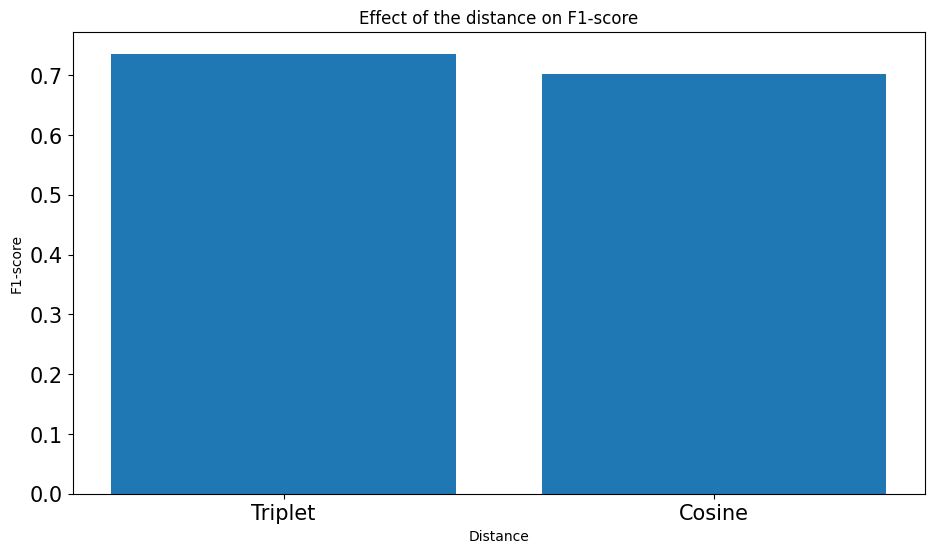

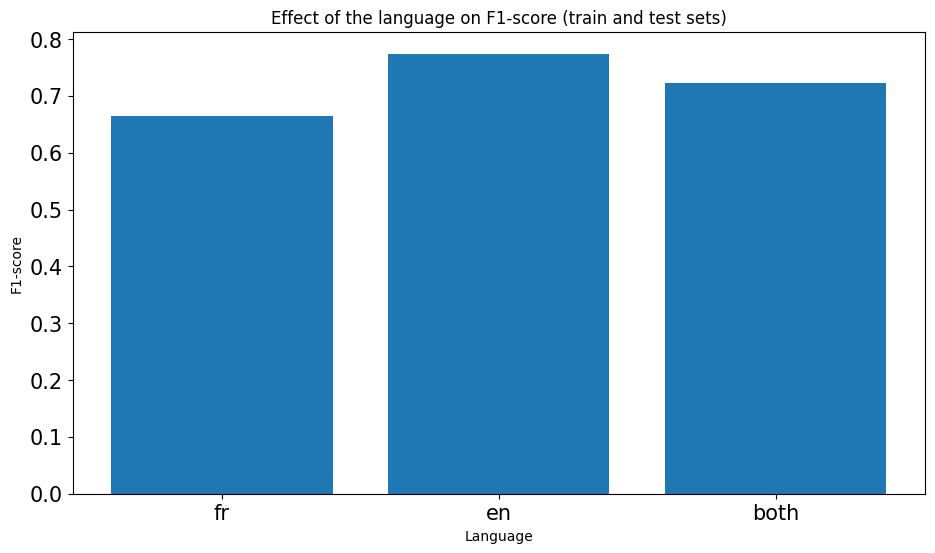

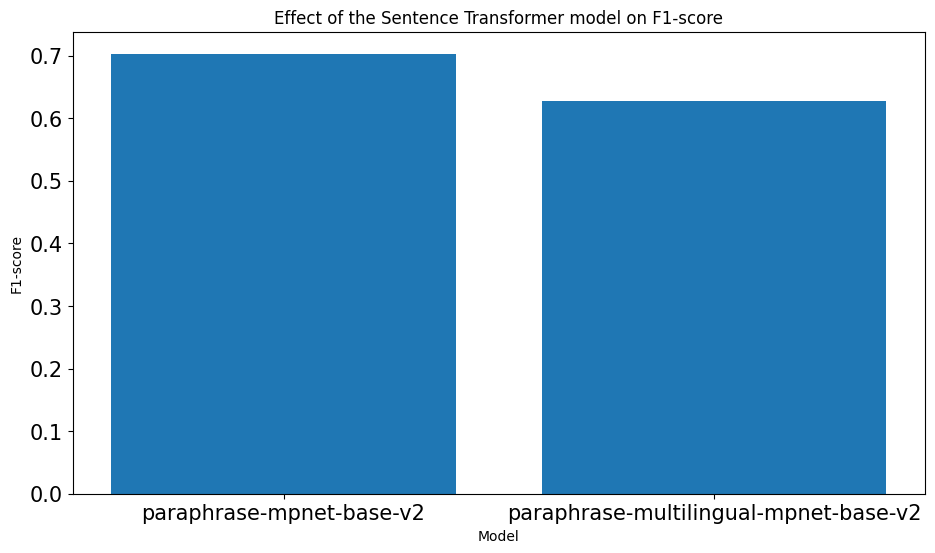

In [ ]:
results, run_times = load_latest_results_data(r'../results/setfit/n_shot')
create_scatter_line_plot(results, 'Effect of the number of shots on F1-score', 'N-shot', 'F1-score')

results, run_times = load_latest_results_data(r'../results/setfit/input_length')
create_bar_plot(results, 'Effect of the length of the input on F1-score (train set only)', 'Number of words', 'F1-score')

results, run_times = load_latest_results_data(r'../results/setfit/distance')
create_bar_plot(results, 'Effect of the distance on F1-score', 'Distance', 'F1-score')

results, run_times = load_latest_results_data(r'../results/setfit/language')
create_bar_plot(results, 'Effect of the language on F1-score (train and test sets)', 'Language', 'F1-score')

results, run_times = load_latest_results_data(r'../results/setfit/model')
create_bar_plot(results, 'Effect of the Sentence Transformer model on F1-score', 'Model', 'F1-score')

## Hyperparameter Optimization (with optuna)

In [ ]:
from typing import Dict, Any, Union
from optuna import Trial

def model_init(params: Dict[str, Any]) -> SetFitModel:
    params = params or {}
    max_iter = params.get("max_iter", 100)
    solver = params.get("solver", "liblinear")
    params = {
        "head_params": {
            "max_iter": max_iter,
            "solver": solver,
        }
    }
    return SetFitModel.from_pretrained("sentence-transformers/paraphrase-multilingual-mpnet-base-v2", **params)

def hp_space(trial: Trial) -> Dict[str, Union[float, int, str]]:
    return {
        "body_learning_rate": trial.suggest_float("body_learning_rate", 1e-6, 1e-3, log=True),
        "num_epochs": trial.suggest_int("num_epochs", 1, 2),
        "batch_size": trial.suggest_categorical("batch_size", [8, 16, 32]),
        "seed": trial.suggest_int("seed", 1, 40),
        "max_iter": trial.suggest_int("max_iter", 50, 300),
        "solver": trial.suggest_categorical("solver", ["newton-cg", "lbfgs", "liblinear"]),
    }
    
new_train_set = Dataset.from_pandas(train_set, split="train")
new_train_set = sample_dataset(new_train_set, label_column="label", num_samples=8)
new_test_set = Dataset.from_pandas(test_set, split="test")

trainer = Trainer(
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    model_init=model_init,
    metric='f1',
)

best_run = trainer.hyperparameter_search(direction="maximize", hp_space=hp_space, n_trials=10)

g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/20 [00:00<?, ? examples/s]

[I 2024-03-06 00:19:50,059] A new study created in memory with name: no-name-6a3e433b-20f4-49db-be27-92e7fbca42a9
Trial: {'body_learning_rate': 1.1267055249587519e-05, 'num_epochs': 2, 'batch_size': 16, 'seed': 13, 'max_iter': 240, 'solver': 'liblinear'}
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
***** Running training *****
  Num unique pairs = 220
  Batch size = 16
  Num epochs = 2
  Total optimization steps = 28


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

{'embedding_loss': 0.2464, 'learning_rate': 3.7556850831958396e-06, 'epoch': 0.07}
{'train_runtime': 17.256, 'train_samples_per_second': 25.962, 'train_steps_per_second': 1.623, 'epoch': 2.0}


***** Running evaluation *****
[I 2024-03-06 00:20:14,451] Trial 0 finished with value: 0.727735368956743 and parameters: {'body_learning_rate': 1.1267055249587519e-05, 'num_epochs': 2, 'batch_size': 16, 'seed': 13, 'max_iter': 240, 'solver': 'liblinear'}. Best is trial 0 with value: 0.727735368956743.
Trial: {'body_learning_rate': 0.00010970810880457966, 'num_epochs': 1, 'batch_size': 16, 'seed': 31, 'max_iter': 61, 'solver': 'newton-cg'}
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
***** Running training *****
  Num unique pairs = 220
  Batch size = 16
  Num epochs = 1
  Total optimization steps = 14


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

{'embedding_loss': 0.2435, 'learning_rate': 5.485405440228983e-05, 'epoch': 0.07}
{'train_runtime': 12.102, 'train_samples_per_second': 18.509, 'train_steps_per_second': 1.157, 'epoch': 1.0}


***** Running evaluation *****
[I 2024-03-06 00:20:33,458] Trial 1 finished with value: 0.6956521739130435 and parameters: {'body_learning_rate': 0.00010970810880457966, 'num_epochs': 1, 'batch_size': 16, 'seed': 31, 'max_iter': 61, 'solver': 'newton-cg'}. Best is trial 0 with value: 0.727735368956743.
Trial: {'body_learning_rate': 0.0005760173228664296, 'num_epochs': 1, 'batch_size': 16, 'seed': 26, 'max_iter': 116, 'solver': 'newton-cg'}
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
***** Running training *****
  Num unique pairs = 220
  Batch size = 16
  Num epochs = 1
  Total optimization steps = 14


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

{'embedding_loss': 0.234, 'learning_rate': 0.0002880086614332148, 'epoch': 0.07}
{'train_runtime': 12.475, 'train_samples_per_second': 17.956, 'train_steps_per_second': 1.122, 'epoch': 1.0}


***** Running evaluation *****
[I 2024-03-06 00:20:52,967] Trial 2 finished with value: 0.0 and parameters: {'body_learning_rate': 0.0005760173228664296, 'num_epochs': 1, 'batch_size': 16, 'seed': 26, 'max_iter': 116, 'solver': 'newton-cg'}. Best is trial 0 with value: 0.727735368956743.
Trial: {'body_learning_rate': 5.312395039278301e-06, 'num_epochs': 2, 'batch_size': 16, 'seed': 24, 'max_iter': 99, 'solver': 'liblinear'}
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
***** Running training *****
  Num unique pairs = 220
  Batch size = 16
  Num epochs = 2
  Total optimization steps = 28


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

{'embedding_loss': 0.2448, 'learning_rate': 1.7707983464261001e-06, 'epoch': 0.07}
{'train_runtime': 23.236, 'train_samples_per_second': 19.28, 'train_steps_per_second': 1.205, 'epoch': 2.0}


***** Running evaluation *****
[I 2024-03-06 00:21:22,966] Trial 3 finished with value: 0.7012345679012346 and parameters: {'body_learning_rate': 5.312395039278301e-06, 'num_epochs': 2, 'batch_size': 16, 'seed': 24, 'max_iter': 99, 'solver': 'liblinear'}. Best is trial 0 with value: 0.727735368956743.
Trial: {'body_learning_rate': 1.148705332426081e-06, 'num_epochs': 2, 'batch_size': 8, 'seed': 33, 'max_iter': 114, 'solver': 'newton-cg'}
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
***** Running training *****
  Num unique pairs = 220
  Batch size = 8
  Num epochs = 2
  Total optimization steps = 56


  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

{'embedding_loss': 0.3052, 'learning_rate': 1.9145088873768018e-07, 'epoch': 0.04}
{'embedding_loss': 0.2172, 'learning_rate': 1.378446398911297e-07, 'epoch': 1.79}
{'train_runtime': 27.615, 'train_samples_per_second': 16.223, 'train_steps_per_second': 2.028, 'epoch': 2.0}


***** Running evaluation *****
[I 2024-03-06 00:21:57,039] Trial 4 finished with value: 0.6553398058252428 and parameters: {'body_learning_rate': 1.148705332426081e-06, 'num_epochs': 2, 'batch_size': 8, 'seed': 33, 'max_iter': 114, 'solver': 'newton-cg'}. Best is trial 0 with value: 0.727735368956743.
Trial: {'body_learning_rate': 4.728450837202361e-05, 'num_epochs': 2, 'batch_size': 32, 'seed': 3, 'max_iter': 105, 'solver': 'lbfgs'}
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
***** Running training *****
  Num unique pairs = 220
  Batch size = 32
  Num epochs = 2
  Total optimization steps = 14


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

{'embedding_loss': 0.2414, 'learning_rate': 2.3642254186011806e-05, 'epoch': 0.14}
{'train_runtime': 32.234, 'train_samples_per_second': 13.898, 'train_steps_per_second': 0.434, 'epoch': 2.0}


***** Running evaluation *****
[I 2024-03-06 00:22:38,105] Trial 5 finished with value: 0.7518796992481203 and parameters: {'body_learning_rate': 4.728450837202361e-05, 'num_epochs': 2, 'batch_size': 32, 'seed': 3, 'max_iter': 105, 'solver': 'lbfgs'}. Best is trial 5 with value: 0.7518796992481203.
Trial: {'body_learning_rate': 5.654337352018526e-05, 'num_epochs': 2, 'batch_size': 16, 'seed': 13, 'max_iter': 135, 'solver': 'newton-cg'}
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
***** Running training *****
  Num unique pairs = 220
  Batch size = 16
  Num epochs = 2
  Total optimization steps = 28


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

{'embedding_loss': 0.2464, 'learning_rate': 1.8847791173395086e-05, 'epoch': 0.07}
{'train_runtime': 22.253, 'train_samples_per_second': 20.132, 'train_steps_per_second': 1.258, 'epoch': 2.0}


***** Running evaluation *****
[I 2024-03-06 00:23:07,745] Trial 6 finished with value: 0.6579439252336449 and parameters: {'body_learning_rate': 5.654337352018526e-05, 'num_epochs': 2, 'batch_size': 16, 'seed': 13, 'max_iter': 135, 'solver': 'newton-cg'}. Best is trial 5 with value: 0.7518796992481203.
Trial: {'body_learning_rate': 1.6399710249376203e-06, 'num_epochs': 2, 'batch_size': 32, 'seed': 36, 'max_iter': 179, 'solver': 'lbfgs'}
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
***** Running training *****
  Num unique pairs = 220
  Batch size = 32
  Num epochs = 2
  Total optimization steps = 14


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

{'embedding_loss': 0.2418, 'learning_rate': 8.199855124688101e-07, 'epoch': 0.14}
{'train_runtime': 26.591, 'train_samples_per_second': 16.848, 'train_steps_per_second': 0.526, 'epoch': 2.0}


***** Running evaluation *****
[I 2024-03-06 00:23:42,603] Trial 7 finished with value: 0.6386946386946387 and parameters: {'body_learning_rate': 1.6399710249376203e-06, 'num_epochs': 2, 'batch_size': 32, 'seed': 36, 'max_iter': 179, 'solver': 'lbfgs'}. Best is trial 5 with value: 0.7518796992481203.
Trial: {'body_learning_rate': 0.0004261759539126457, 'num_epochs': 1, 'batch_size': 32, 'seed': 13, 'max_iter': 244, 'solver': 'newton-cg'}
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
***** Running training *****
  Num unique pairs = 220
  Batch size = 32
  Num epochs = 1
  Total optimization steps = 7


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

{'embedding_loss': 0.2482, 'learning_rate': 0.0004261759539126457, 'epoch': 0.14}
{'train_runtime': 12.904, 'train_samples_per_second': 17.359, 'train_steps_per_second': 0.542, 'epoch': 1.0}


***** Running evaluation *****
[I 2024-03-06 00:24:04,405] Trial 8 finished with value: 0.6866485013623979 and parameters: {'body_learning_rate': 0.0004261759539126457, 'num_epochs': 1, 'batch_size': 32, 'seed': 13, 'max_iter': 244, 'solver': 'newton-cg'}. Best is trial 5 with value: 0.7518796992481203.
Trial: {'body_learning_rate': 6.876468565154054e-06, 'num_epochs': 2, 'batch_size': 8, 'seed': 1, 'max_iter': 129, 'solver': 'lbfgs'}
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
***** Running training *****
  Num unique pairs = 220
  Batch size = 8
  Num epochs = 2
  Total optimization steps = 56


  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

{'embedding_loss': 0.3025, 'learning_rate': 1.1460780941923422e-06, 'epoch': 0.04}
{'embedding_loss': 0.0459, 'learning_rate': 8.251762278184864e-07, 'epoch': 1.79}
{'train_runtime': 41.174, 'train_samples_per_second': 10.881, 'train_steps_per_second': 1.36, 'epoch': 2.0}


***** Running evaluation *****
[I 2024-03-06 00:24:53,398] Trial 9 finished with value: 0.7405405405405405 and parameters: {'body_learning_rate': 6.876468565154054e-06, 'num_epochs': 2, 'batch_size': 8, 'seed': 1, 'max_iter': 129, 'solver': 'lbfgs'}. Best is trial 5 with value: 0.7518796992481203.


In [ ]:
print(best_run)

BestRun(run_id='5', objective=0.7518796992481203, hyperparameters={'body_learning_rate': 4.728450837202361e-05, 'num_epochs': 2, 'batch_size': 32, 'seed': 3, 'max_iter': 105, 'solver': 'lbfgs'}, backend=<optuna.study.study.Study object at 0x0000022B91EB03D0>)


In [ ]:
trainer.apply_hyperparameters(best_run.hyperparameters, final_model=True)
trainer.train()

model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
***** Running training *****
  Num unique pairs = 220
  Batch size = 32
  Num epochs = 2
  Total optimization steps = 14


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

{'embedding_loss': 0.2414, 'learning_rate': 2.3642254186011806e-05, 'epoch': 0.14}
{'train_runtime': 38.209, 'train_samples_per_second': 11.725, 'train_steps_per_second': 0.366, 'epoch': 2.0}


In [ ]:
trainer.evaluate()

***** Running evaluation *****


{'f1': 0.7518796992481203}